# 1. Imports & Config

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from numpy import ndarray
from matplotlib.pyplot import subplots, show
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# model building imports
import keras
from keras import Model, Sequential, Input
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import LeakyReLU
from keras.ops import add
from keras.utils import to_categorical
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import CategoricalAccuracy, AUC, F1Score
from keras.callbacks import ModelCheckpoint, CSVLogger, LearningRateScheduler ,ReduceLROnPlateau, EarlyStopping
from keras.utils import Sequence, load_img, img_to_array

import keras_tuner
# augmentation operations
from keras.layers import RandomBrightness, RandomFlip, RandomRotation, RandomContrast
from keras.layers import Pipeline
from keras.layers import BatchNormalization
from keras.layers import Dropout

In [2]:
import tensorflow as tf

# List all physical GPUs
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)


Available GPUs: []


In [3]:
print('num gpus:', len(tf.config.list_physical_devices('GPU')))

num gpus: 0


In [4]:
tf.config.run_functions_eagerly(True)

In [6]:
# importing the dataset
metadata = pd.read_csv('../DL/metadata.csv')
#metadata = pd.read_csv('../Data/rare_species/metadata.csv')
metadata.sample(5)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
10301,a675da48-fb31-4047-82d9-68c55d25fafa,22521703,128466,animalia,chordata,cercopithecidae,chordata_cercopithecidae/22521703_128466_eol-f...
10991,8188bb2f-e849-4bd1-a816-1696012ab875,20738647,46559412,animalia,chordata,pontoporiidae,chordata_pontoporiidae/20738647_46559412_eol-f...
11180,ee2bbbc3-852e-42a6-990e-e05c6d4a885a,21985166,2920193,animalia,chordata,ranidae,chordata_ranidae/21985166_2920193_eol-full-siz...
9076,4a740401-4ef2-4c8a-be35-fa02edad4586,20163023,794282,animalia,chordata,testudinidae,chordata_testudinidae/20163023_794282_eol-full...
3881,ec47ede5-8a06-4a6c-99d1-196c01f4bb91,20809237,46560594,animalia,chordata,rajidae,chordata_rajidae/20809237_46560594_eol-full-si...


In [7]:
# applying the filepath
metadata['file_path'] = metadata['file_path'].apply(lambda x: os.path.join('../rare_species 1', x))

In [10]:
metadata.sample(5)

,rare_species_id,eol_content_id,eol_page_id,kingdom,phylum,family,file_path
4520,e36e44ec-6c15-4b9a-8cf7-537c8067584a,22513666,45514059,animalia,chordata,brachypteraciidae,../rare_species 1\chordata_brachypteraciidae/2...
5396,67d3d8ea-4051-4ad3-80e7-313586642567,21801345,4357897,animalia,chordata,salamandridae,../rare_species 1\chordata_salamandridae/21801...
6624,f669bf46-3aec-40bb-982b-892448ca3424,29910720,47363970,animalia,chordata,strigidae,../rare_species 1\chordata_strigidae/29910720_...
16,e09db146-4447-4863-a0cf-23b85c4cf293,29898060,46559814,animalia,chordata,carcharhinidae,../rare_species 1\chordata_carcharhinidae/2989...
1254,471c345a-83f0-4608-8b96-ccd5cfda73a9,22946554,52572074,animalia,chordata,dasyatidae,../rare_species 1\chordata_dasyatidae/22946554...


# 2.  Preprocessing

In [11]:
metadata.phylum.unique()

array(['mollusca', 'chordata', 'arthropoda', 'echinodermata', 'cnidaria'],
      dtype=object)

In [12]:
print(metadata['family'].value_counts())

family
dactyloidae        300
cercopithecidae    300
formicidae         291
carcharhinidae     270
salamandridae      270
                  ... 
cyprinodontidae     30
alligatoridae       30
balaenidae          30
goodeidae           30
siluridae           29
Name: count, Length: 202, dtype: int64


In [13]:
num_classes = metadata['family'].nunique()
num_classes

202

our dataset is inbalaced and has a length of 202 classes

In [14]:
# Transforming our target and feature into a int
label_encoder = LabelEncoder()
metadata['target'] = label_encoder.fit_transform(metadata['family'])


In [15]:
metadata['target'].sample(10)

7268     163
11856      1
7685      45
6529     198
9694     119
1959     163
4741      81
2707      99
7715      43
5311     199
Name: target, dtype: int64

## Cheking for misslabeled images/ images that are not supposed to be in our dataset

In [20]:
import os
from keras.applications import EfficientNetB0
from keras.applications.efficientnet import preprocess_input, decode_predictions
from keras.utils import load_img, img_to_array
import numpy as np
from tqdm import tqdm

# Load model
model = EfficientNetB0(weights="imagenet", include_top=True)

# Set your correct images base folder
base_path = "../DL"  # <-- Adjust if needed!

weird_samples = []

for _, row in tqdm(metadata.iterrows(), total=len(metadata)):
    original_path = row['file_path']
    true_label = row['family']

    try:
        # Fix the path: remove old base ("../rare_species 1") and join with the new base
        sub_path = os.path.relpath(original_path, start='../rare_species 1')
        path = os.path.join(base_path, sub_path)
        path = os.path.normpath(path)

        # Load and process the image
        img = load_img(path, target_size=(224, 224))
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)

        preds = model.predict(x, verbose=0)
        top_pred = decode_predictions(preds, top=1)[0][0]

        label = top_pred[1]
        prob = top_pred[2]

        if label in ['person', 'plate', 'restaurant', 'spaghetti', 'burrito', 'banana'] and prob > 0.5:
            print(f"🚨 Mismatch: Image predicted as '{label}' ({prob:.2f}) but labeled as '{true_label}'")
            weird_samples.append((path, label, prob, true_label))

    except Exception as e:
        print(f"Error reading {path}: {e}")

  0%|          | 0/11983 [00:00<?, ?it/s]C:\Users\Ricardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\tensorflow\python\data\ops\structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step


 64%|██████▍   | 7671/11983 [22:45<13:52,  5.18it/s]

🚨 Mismatch: Image predicted as 'plate' (0.73) but labeled as 'serranidae'


 85%|████████▌ | 10194/11983 [30:12<05:32,  5.39it/s]C:\Users\Ricardo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\PIL\Image.py:3442: DecompressionBombWarning: Image size (115600000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
100%|██████████| 11983/11983 [35:28<00:00,  5.63it/s]


### Spliting the data

In [13]:
# SSpliting the data while keeping the same distribuition of classes(target) - 70%/20%/10%

train, temp = train_test_split(metadata, test_size=0.3,stratify=metadata['target'],random_state=1)

val, test = train_test_split(temp,test_size=1/3,stratify=temp['target'],random_state=1)

In [14]:
train.shape , val.shape , test.shape

((8388, 8), (2396, 8), (1199, 8))

Loading the images

In [15]:
# def load_image(df, path='file_path', label='target', image_size=(256, 256)):
#     X = []
#     y = []

#     for _, row in df.iterrows():
#         image = keras.utils.load_img(row[path], target_size=image_size)
#         input_arr = keras.utils.img_to_array(image) / 255.0  # Normalize
#         X.append(input_arr)
#         y.append(row[label])
    
#     return np.array(X), np.array(y)

In [16]:
# X_train , y_train = load_image(train)
# X_val , y_val = load_image(val)
# X_test , y_test = load_image(test)

In [17]:
# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [18]:
# # one-hot encoding the target
# y_train = to_categorical(y_train, num_classes=num_classes)
# y_val = to_categorical(y_val, num_classes=num_classes)
# y_test = to_categorical(y_test, num_classes=num_classes)

In [19]:
# X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

In [20]:
# class ImageGenerator(Sequence):
#     def __init__(self, df, image_size=(256, 256), batch_size=32, path_col='file_path', label_col='target', num_classes=202, shuffle=True):
#         self.df = df.reset_index(drop=True)
#         self.image_size = image_size
#         self.batch_size = batch_size
#         self.path_col = path_col
#         self.label_col = label_col
#         self.num_classes = num_classes
#         self.shuffle = shuffle
#         self.indexes = np.arange(len(self.df))
#         self.on_epoch_end()

#     def __len__(self):
#         return int(np.ceil(len(self.df) / self.batch_size))

#     def __getitem__(self, index):
#         batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
#         batch_df = self.df.iloc[batch_indexes]
#         return self.__data_generation(batch_df)

#     def on_epoch_end(self):
#         if self.shuffle:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, batch_df):
#         X = []
#         y = []
#         for _, row in batch_df.iterrows():
#             img = load_img(row[self.path_col], target_size=self.image_size)
#             img_array = img_to_array(img) / 255.0
#             X.append(img_array)
#             y.append(to_categorical(row[self.label_col], num_classes=self.num_classes))
#         return np.array(X), np.array(y)


In [21]:
# train_df = ImageGenerator(train, batch_size=32, image_size=(128, 128), num_classes=num_classes)
# val_df = ImageGenerator(val, batch_size=32, image_size=(128, 128), num_classes=num_classes, shuffle=False)
# test_df = ImageGenerator(test, batch_size=32, image_size=(128, 128), num_classes=num_classes, shuffle=False)


In [22]:
# def show_image(array: ndarray) -> None:
#     """
#     Prints image encoded as a numpy array (uint8)
#     """

#     figure, axis = subplots(frameon=False)
#     axis.imshow(array, aspect="equal")
#     axis.set_axis_off()
#     show()

In [23]:
# # Show example
# train_idx = 1000
# train_example = train[train_idx]
# show_image(train_example)

In [24]:
import tensorflow as tf

IMG_SIZE = (128, 128)
BATCH_SIZE = 16
AUTOTUNE = tf.data.AUTOTUNE

def df_to_dataset(dataframe, augment=False, shuffle=True):
    filepaths = dataframe['file_path'].values
    labels = dataframe['target'].values

    ds = tf.data.Dataset.from_tensor_slices((filepaths, labels))

    def process(file_path, label):
        image = tf.io.read_file(file_path)
        image = tf.image.decode_image(image, channels=3, expand_animations=False)
        image = tf.image.resize(image, IMG_SIZE)
        image = tf.cast(image, tf.float32) / 255.0
        if augment:
            image = tf.image.random_flip_left_right(image)
            image = tf.image.random_brightness(image, max_delta=0.1)
        return image, tf.one_hot(label, depth=num_classes)

    ds = ds.map(process, num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(buffer_size=1000)

    return ds.batch(BATCH_SIZE).prefetch(AUTOTUNE)


In [25]:
train_df = df_to_dataset(train, augment=True)
val_df = df_to_dataset(val, augment=False)
test_df = df_to_dataset(test, augment=False, shuffle=False)


I0000 00:00:1745406345.169835    4186 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6134 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9
/home/ruben/anaconda3/envs/DeepLearn/lib/python3.12/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


# 3. Models

In [26]:
augmentation_layer = Sequential(
    [
        RandomBrightness(factor=0.2, value_range=(0.0, 1.0)),
        RandomFlip(),
        RandomRotation(factor=0.2, fill_mode="reflect"),
        RandomContrast(factor = 0.4, value_range=(0, 1), seed=1)
    ], 
    name="augmentation_layer")


In [27]:
lr_reduction = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0, verbose = 1)

In [28]:
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights = True)

In [29]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy]

In [30]:
input_shape = (128, 128,3)

epochs = 500
batch_size = 16

## Model 1

In [34]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Dense, 
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.regularizers import l2


def build_transfg_like(input_shape, num_classes):
    weight_decay = 1e-4

    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,

        Conv2D(32, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 128 → 64

        Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 64 → 32

        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 32 → 16
        Dropout(0.2),

        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 16 → 8

        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 8 → 4
        Dropout(0.3),

        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 4 → 2

        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 2 → 1 (last one!)
        Dropout(0.4),

        # No more pooling — spatial size is 1x1 here
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.4),

        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),

        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),

        GlobalAveragePooling2D(),

        Dense(256, activation="relu", kernel_regularizer=l2(weight_decay)),
        Dropout(0.5),

        Dense(num_classes, activation="softmax")
    ], name="TransFG_CNN")

    model.summary()
    return model


    

In [35]:
model_1 = build_transfg_like(input_shape=input_shape, num_classes=num_classes)

model_1.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "TransFG_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 8, 8, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 8, 8, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 4, 4, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 2, 2, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 2, 2, 512)      │     2,359,80

 Total params: 8,005,770 (30.54 MB)

 Trainable params: 8,000,714 (30.52 MB)

 Non-trainable params: 5,056 (19.75 KB)

In [36]:
# train the model
_1 = model_1.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs,  
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

Epoch 1/500


I0000 00:00:1745352062.401320    6093 cuda_dnn.cc:529] Loaded cuDNN version 90800


525/525 ━━━━━━━━━━━━━━━━━━━━ 53s 93ms/step - accuracy: 0.0170 - loss: 5.7160 - val_accuracy: 0.0476 - val_loss: 5.2972 - learning_rate: 0.0100
Epoch 2/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 92ms/step - accuracy: 0.0522 - loss: 5.3557 - val_accuracy: 0.0430 - val_loss: 5.2112 - learning_rate: 0.0100
Epoch 3/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.0534 - loss: 5.2594 - val_accuracy: 0.0659 - val_loss: 5.1247 - learning_rate: 0.0100
Epoch 4/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 92ms/step - accuracy: 0.0710 - loss: 5.1692 - val_accuracy: 0.0810 - val_loss: 5.0723 - learning_rate: 0.0100
Epoch 5/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 93ms/step - accuracy: 0.0724 - loss: 5.1272 - val_accuracy: 0.0785 - val_loss: 5.0187 - learning_rate: 0.0100
Epoch 6/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 49s 91ms/step - accuracy: 0.0760 - loss: 5.0769 - val_accuracy: 0.0751 - val_loss: 5.0522 - learning_rate: 0.0100
Epoch 7/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 50s 91ms/step - accuracy: 0.0767 - loss: 

KeyboardInterrupt: 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, MaxPooling2D, Dropout, Dense,
    BatchNormalization, GlobalAveragePooling2D
)
from tensorflow.keras.regularizers import l2

def build_transfg_like(input_shape, num_classes):
    weight_decay = 1e-4

    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,

        # Block 1
        Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        # MaxPooling2D((2, 2)),  # 128 → 64

        # Block 2
        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 64 → 32
        Dropout(0.2),

        # Block 3
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 32 → 16

        # Block 4
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 16 → 8
        Dropout(0.3),

        # Block 5
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 8 → 4

        # Block 6
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 4 → 2

        # Block 7
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 2 → 1
        Dropout(0.4),

        # Final convs without pooling
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.4),

        GlobalAveragePooling2D(),

        Dense(1024, activation="relu", kernel_regularizer=l2(weight_decay)),
        Dropout(0.5),

        Dense(512, activation="relu", kernel_regularizer=l2(weight_decay)),
        Dropout(0.5),

        Dense(num_classes, activation="softmax")
    ], name="TransFG_CNN_Large")

    model.summary()
    return model

optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, f1_score]

model_2 = build_transfg_like(input_shape=input_shape, num_classes=num_classes)

model_2.compile(loss=loss, optimizer=optimizer, metrics=metrics)


Model: "TransFG_CNN_Large"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ augmentation_layer (Sequential) │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 128, 128, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_33          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 128, 128, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_34          │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_21 (MaxPooling2D) │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_35          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 64, 64, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_36          │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_22 (MaxPooling2D) │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_37          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 32, 32, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_38          │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_23 (MaxPooling2D) │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 16, 16, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_39          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 16, 16, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_40          │ (None, 16, 16, 512)    │         2,048 │
│ (BatchNormalization)            │                        │             

 Total params: 43,618,570 (166.39 MB)

 Trainable params: 43,605,514 (166.34 MB)

 Non-trainable params: 13,056 (51.00 KB)

In [40]:
_2 = model_2.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs,  
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

Epoch 1/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 89s 167ms/step - accuracy: 0.0138 - f1_score: 0.0038 - loss: 6.3505 - val_accuracy: 0.0280 - val_f1_score: 0.0022 - val_loss: 5.8418 - learning_rate: 0.0100
Epoch 2/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 85s 158ms/step - accuracy: 0.0319 - f1_score: 0.0040 - loss: 5.9401 - val_accuracy: 0.0572 - val_f1_score: 0.0038 - val_loss: 5.7947 - learning_rate: 0.0100
Epoch 3/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 84s 158ms/step - accuracy: 0.0399 - f1_score: 0.0041 - loss: 5.8493 - val_accuracy: 0.0618 - val_f1_score: 0.0045 - val_loss: 5.7660 - learning_rate: 0.0100
Epoch 4/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 85s 158ms/step - accuracy: 0.0424 - f1_score: 0.0043 - loss: 5.8235 - val_accuracy: 0.0559 - val_f1_score: 0.0053 - val_loss: 5.7688 - learning_rate: 0.0100
Epoch 5/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 85s 158ms/step - accuracy: 0.0446 - f1_score: 0.0044 - loss: 5.7703 - val_accuracy: 0.0543 - val_f1_score: 0.0035 - val_loss: 5.6886 - learning_rate: 0.0100
Epoch 6/50

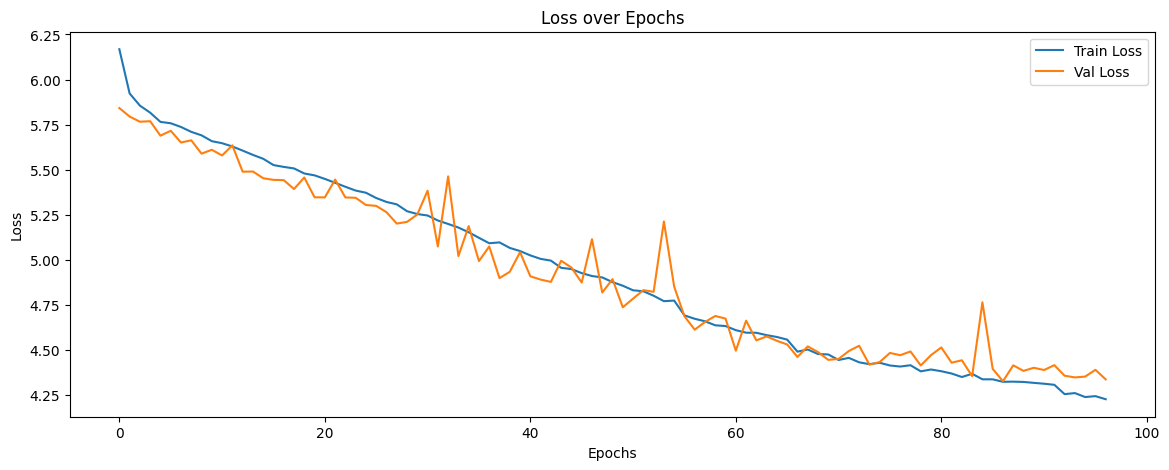

In [41]:
plt.figure(figsize=(14, 5))

plt.plot(_2.history['loss'], label='Train Loss')
plt.plot(_2.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


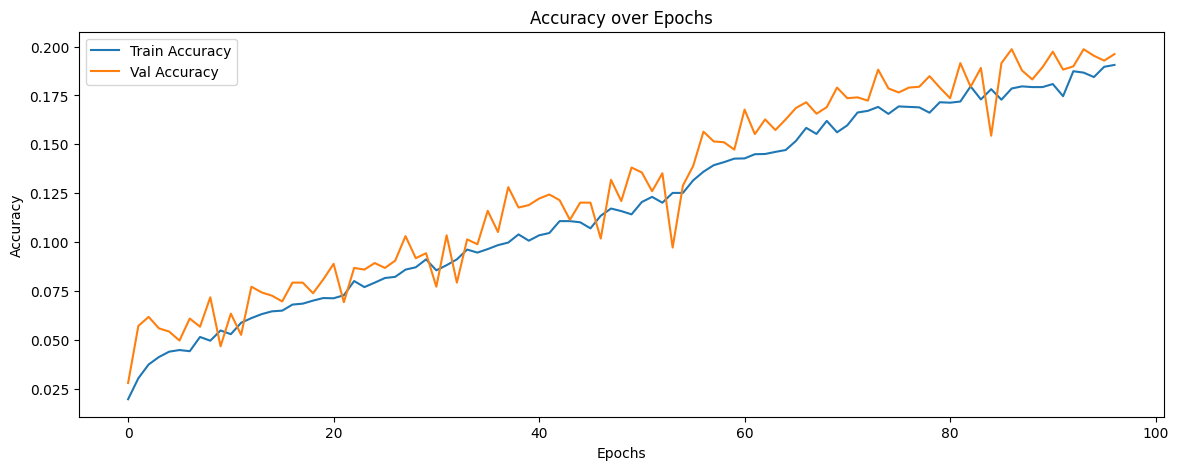

In [42]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_2.history['accuracy'], label='Train Accuracy')
plt.plot(_2.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()


plt.show()

In [ ]:

def build_transfg_like(input_shape, num_classes):
    weight_decay = 1e-4

    model = Sequential([
        Input(shape=input_shape),
        augmentation_layer,

        # Block 1
        Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        # MaxPooling2D((2, 2)),  # 128 → 64

        # Block 2
        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 64 → 32
        Dropout(0.2),

        # Block 3
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(256, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 32 → 16

        # Block 4
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 16 → 8
        Dropout(0.2),

        # Block 5
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 8 → 4

        # Block 6
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        #MaxPooling2D((2, 2)),  # 4 → 2

        # Block 7
        Conv2D(1024, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        MaxPooling2D((2, 2)),  # 2 → 1
        Dropout(0.2),

        # Final convs without pooling
        Conv2D(512, (3, 3), activation="relu", padding="same", kernel_regularizer=l2(weight_decay)),
        BatchNormalization(),
        Dropout(0.2),

        GlobalAveragePooling2D(),

        Dense(1024, activation="relu", kernel_regularizer=l2(weight_decay)),
        Dropout(0.2),

        Dense(512, activation="relu", kernel_regularizer=l2(weight_decay)),
        Dropout(0.2),

        Dense(num_classes, activation="softmax")
    ], name="TransFG_CNN_Large")

    model.summary()
    return model

optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

In [ ]:
# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, f1_score]

model_3 = build_transfg_like(input_shape=input_shape, num_classes=num_classes)

model_3.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [ ]:
_3 = model_3.fit(
    train_df,
    validation_data=val_df,
    epochs=epochs,  
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

## Model 4

In [31]:
from keras.applications import ResNet50
from keras.layers import GlobalAveragePooling2D

In [44]:


def build_resnet50_with_head(input_shape=input_shape, num_classes=num_classes):

    inputs = Input(shape=input_shape, name="input_layer")
    x = augmentation_layer(inputs)
    base_model = ResNet50(include_top=False, weights='imagenet', input_tensor=x)
    base_model.trainable = True

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=inputs, outputs=outputs, name="ResNet50_CustomHead")
    
    model.summary()
    
    return model


In [45]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, f1_score]

In [46]:
model_4 = build_resnet50_with_head()

model_4.compile(loss=loss, optimizer=optimizer, metrics=metrics)

Model: "ResNet50_CustomHead"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ augmentation_layer  │ (None, 128, 128,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ augmentation_lay… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c

 Total params: 24,164,170 (92.18 MB)

 Trainable params: 24,111,050 (91.98 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [47]:
# train the model
_4 = model_4.fit(
    train_df,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=val_df,
    callbacks= [lr_reduction , early_stop]
) 

Epoch 1/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 150s 282ms/step - accuracy: 0.0453 - f1_score: 0.0088 - loss: 5.2763 - val_accuracy: 0.0150 - val_f1_score: 4.7095e-04 - val_loss: 5.3920 - learning_rate: 0.0100
Epoch 2/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 152s 287ms/step - accuracy: 0.1360 - f1_score: 0.0310 - loss: 4.5196 - val_accuracy: 0.1661 - val_f1_score: 0.0476 - val_loss: 4.1533 - learning_rate: 0.0100
Epoch 3/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 154s 290ms/step - accuracy: 0.1757 - f1_score: 0.0588 - loss: 4.1448 - val_accuracy: 0.2241 - val_f1_score: 0.0987 - val_loss: 3.7063 - learning_rate: 0.0100
Epoch 4/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 151s 285ms/step - accuracy: 0.2240 - f1_score: 0.1020 - loss: 3.7779 - val_accuracy: 0.2137 - val_f1_score: 0.1128 - val_loss: 3.7524 - learning_rate: 0.0100
Epoch 5/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 150s 283ms/step - accuracy: 0.2620 - f1_score: 0.1408 - loss: 3.4922 - val_accuracy: 0.2951 - val_f1_score: 0.1816 - val_loss: 3.2427 - learning_rate: 0.0100
E

In [ ]:
y_prob = model_5.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids
y_true = val['target'].values                        # or:  val_df.df['target'].values

assert len(y_true) == len(y_pred), "mismatch in lengths!"
from sklearn.metrics import classification_report

target_names = label_encoder.classes_

report_df = (
    pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
    )
    .transpose()
    .drop(index=["accuracy", "macro avg", "weighted avg"])
    .sort_values("recall")              
)

pd.set_option("display.max_rows", None)
display(report_df.head(20))               


In [32]:
res50model = Sequential()

res50model.add(Input(shape=(128, 128, 3)))
res50model.add(augmentation_layer)

# Load base model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # freeze for now
res50model.add(base_model)

res50model.add(GlobalAveragePooling2D())

res50model.add(Dense(2560, activation='relu'))
res50model.add(BatchNormalization())
res50model.add(Dropout(0.4))

res50model.add(Dense(1024, activation='relu'))
res50model.add(BatchNormalization())
res50model.add(Dropout(0.4))

res50model.add(Dense(num_classes, activation='softmax'))

# Compile
optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True, name="SGD")
loss = CategoricalCrossentropy(label_smoothing=0.1, name="smoothed_loss")


categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [
    categorical_accuracy,
    f1_score]


In [33]:
optimizer = SGD(learning_rate=0.01, name="optimizer")
loss = CategoricalCrossentropy(name="loss")

# metrics
categorical_accuracy = CategoricalAccuracy(name="accuracy")
f1_score = F1Score(average="macro", name="f1_score")
metrics = [categorical_accuracy, f1_score]
model_5 = res50model
model_5.compile(loss=loss, optimizer=optimizer, metrics=metrics)

In [34]:
_5 = model_5.fit(
    train_df,
    batch_size=batch_size,
    epochs=15,
    validation_data=val_df,
    callbacks= [lr_reduction , early_stop])

Epoch 1/15


I0000 00:00:1745406391.368449    4186 cuda_dnn.cc:529] Loaded cuDNN version 90800


525/525 ━━━━━━━━━━━━━━━━━━━━ 97s 177ms/step - accuracy: 0.0178 - f1_score: 0.0079 - loss: 6.1081 - val_accuracy: 0.0217 - val_f1_score: 0.0023 - val_loss: 5.4782 - learning_rate: 0.0100
Epoch 2/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 94s 176ms/step - accuracy: 0.0301 - f1_score: 0.0113 - loss: 5.6678 - val_accuracy: 0.0142 - val_f1_score: 0.0027 - val_loss: 5.8411 - learning_rate: 0.0100
Epoch 3/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 94s 176ms/step - accuracy: 0.0371 - f1_score: 0.0134 - loss: 5.5435 - val_accuracy: 0.0326 - val_f1_score: 0.0074 - val_loss: 5.4182 - learning_rate: 0.0100
Epoch 4/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 94s 177ms/step - accuracy: 0.0462 - f1_score: 0.0140 - loss: 5.4379 - val_accuracy: 0.0422 - val_f1_score: 0.0079 - val_loss: 5.3944 - learning_rate: 0.0100
Epoch 5/15
525/525 ━━━━━━━━━━━━━━━━━━━━ 94s 177ms/step - accuracy: 0.0378 - f1_score: 0.0111 - loss: 5.3850 - val_accuracy: 0.0301 - val_f1_score: 0.0075 - val_loss: 5.3287 - learning_rate: 0.0100
Epoch 6/15
525/525 ━━━━━━━

In [35]:
for layer in base_model.layers[-50:]:
    layer.trainable = True

# Recompile with smaller learning rate
model_5.compile(
    optimizer=SGD(learning_rate=1e-4, momentum=0.9, nesterov=True, name="SGD_finetune"),
    loss=loss,
    metrics=metrics
)

# Train further
_5= model_5.fit(
    train_df,
    validation_data=val_df,
    epochs=500,
    callbacks=[lr_reduction, early_stop],
    verbose=1
)

Epoch 1/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 232ms/step - accuracy: 0.0329 - f1_score: 0.0140 - loss: 5.5439 - val_accuracy: 0.0338 - val_f1_score: 0.0057 - val_loss: 5.2958 - learning_rate: 1.0000e-04
Epoch 2/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 231ms/step - accuracy: 0.0408 - f1_score: 0.0146 - loss: 5.1905 - val_accuracy: 0.0409 - val_f1_score: 0.0070 - val_loss: 5.0851 - learning_rate: 1.0000e-04
Epoch 3/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 231ms/step - accuracy: 0.0450 - f1_score: 0.0137 - loss: 5.0691 - val_accuracy: 0.0330 - val_f1_score: 0.0067 - val_loss: 5.1877 - learning_rate: 1.0000e-04
Epoch 4/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 231ms/step - accuracy: 0.0574 - f1_score: 0.0170 - loss: 4.9968 - val_accuracy: 0.0626 - val_f1_score: 0.0210 - val_loss: 4.9335 - learning_rate: 1.0000e-04
Epoch 5/500
525/525 ━━━━━━━━━━━━━━━━━━━━ 123s 231ms/step - accuracy: 0.0606 - f1_score: 0.0195 - loss: 4.9205 - val_accuracy: 0.0689 - val_f1_score: 0.0176 - val_loss: 4.7265 - learning_ra

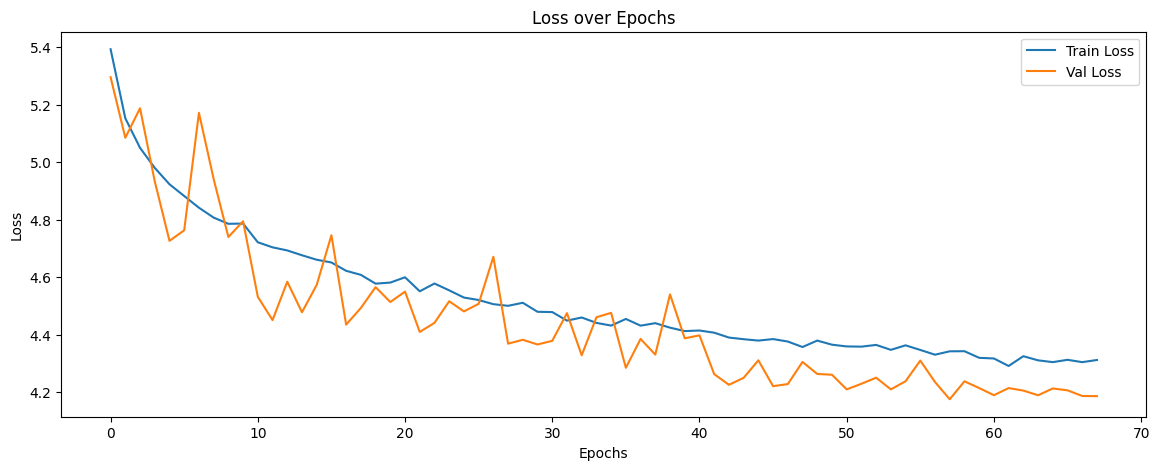

In [ ]:

plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_5.history['loss'], label='Train Loss')
plt.plot(_5.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() 

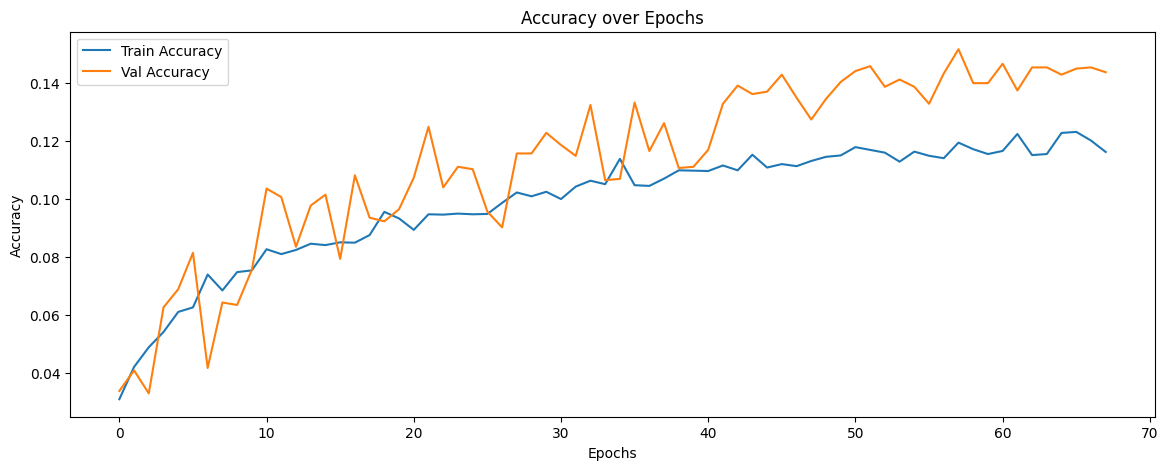

In [ ]:
plt.figure(figsize=(14, 5))

# Plot accuracy
plt.plot(_6.history['accuracy'], label='Train Accuracy')
plt.plot(_6.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [ ]:
y_prob = model_5.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids

NameError: name 'model_4' is not defined

In [39]:
y_true = val['target'].values                        # or:  val_df.df['target'].values

assert len(y_true) == len(y_pred), "mismatch in lengths!"

In [41]:
from sklearn.metrics import classification_report


In [42]:
target_names = label_encoder.classes_

report_df = (
    pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
    )
    .transpose()
    .drop(index=["accuracy", "macro avg", "weighted avg"])
    .sort_values("recall")              
)

pd.set_option("display.max_rows", None)
display(report_df.head(20))               


,precision,recall,f1-score,support
accipitridae,0.0,0.0,0.0,24.0
acipenseridae,0.0,0.0,0.0,18.0
acroporidae,0.0,0.0,0.0,42.0
agamidae,0.0,0.0,0.0,12.0
agariciidae,0.0,0.0,0.0,24.0
albulidae,0.0,0.0,0.0,6.0
alcedinidae,0.0,0.0,0.0,6.0
alligatoridae,0.0,0.0,0.0,6.0
alopiidae,0.0,0.0,0.0,12.0
ambystomatidae,0.0,0.0,0.0,12.0


## Eficient Net V2S

In [48]:
from keras.applications import EfficientNetV2S
from keras.models import Model
from keras.layers import Dense, Dropout, GlobalAveragePooling2D, Input

def build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes):
    base_model = EfficientNetV2S(
        include_top=False,
        weights="imagenet",
        input_shape=input_shape,
        include_preprocessing=True
    )

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.5)(x)
    output = Dense(num_classes, activation="softmax")(x)

    model = Model(inputs=base_model.input, outputs=output, name="EfficientNetV2S_Custom")
    return model


In [52]:
effnet = build_efficientnetv2s_model(input_shape=input_shape, num_classes=num_classes)

effnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss=CategoricalCrossentropy(),
    metrics=[CategoricalAccuracy(), f1_score]
)

In [53]:
from keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='efficientnetv2s_best_model.keras',  # or .h5
    monitor='val_loss',                    
    save_best_only=True,
    save_weights_only=False,                   # True = only weights, False = full model
    verbose=1
)


In [54]:
_6 = effnet.fit(
    train_df,
    validation_data=val_df,
    epochs=200,
    callbacks=[early_stop, lr_reduction, checkpoint_cb],
    verbose=1
)

Epoch 1/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.0345 - f1_score: 0.0391 - loss: 5.2284
Epoch 1: val_loss improved from inf to 4.57132, saving model to efficientnetv2s_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 652s 1s/step - categorical_accuracy: 0.0345 - f1_score: 0.0390 - loss: 5.2280 - val_categorical_accuracy: 0.1260 - val_f1_score: 0.0355 - val_loss: 4.5713 - learning_rate: 1.0000e-04
Epoch 2/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.1408 - f1_score: 0.0405 - loss: 4.3643
Epoch 2: val_loss improved from 4.57132 to 3.77829, saving model to efficientnetv2s_best_model.keras
525/525 ━━━━━━━━━━━━━━━━━━━━ 649s 1s/step - categorical_accuracy: 0.1408 - f1_score: 0.0405 - loss: 4.3640 - val_categorical_accuracy: 0.2154 - val_f1_score: 0.0779 - val_loss: 3.7783 - learning_rate: 1.0000e-04
Epoch 3/200
525/525 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - categorical_accuracy: 0.2336 - f1_score: 0.0898 - loss: 3.6491
Epoch 3: val_loss improved 

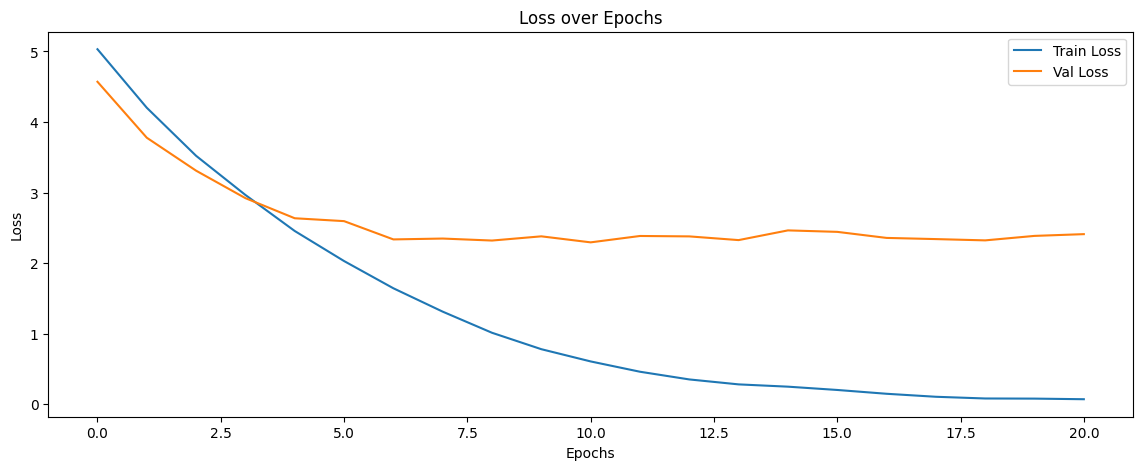

In [55]:

plt.figure(figsize=(14, 5))

# Plot loss
plt.plot(_6.history['loss'], label='Train Loss')
plt.plot(_6.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show() 

In [56]:
y_prob = effnet.predict(val_df, verbose=1)      # shape: (N, 202)
y_pred = np.argmax(y_prob, axis=1)               # predicted class ids

150/150 ━━━━━━━━━━━━━━━━━━━━ 30s 189ms/step


In [57]:
y_true = val['target'].values                        # or:  val_df.df['target'].values

assert len(y_true) == len(y_pred), "mismatch in lengths!"

In [58]:
from sklearn.metrics import classification_report


In [59]:
target_names = label_encoder.classes_

report_df = (
    pd.DataFrame(
        classification_report(
            y_true,
            y_pred,
            target_names=target_names,
            output_dict=True,
            zero_division=0
        )
    )
    .transpose()
    .drop(index=["accuracy", "macro avg", "weighted avg"])
    .sort_values("recall")              
)

pd.set_option("display.max_rows", None)
display(report_df.head(202))               


,precision,recall,f1-score,support
accipitridae,0.000000,0.000000,0.000000,24.0
acipenseridae,0.000000,0.000000,0.000000,18.0
agamidae,0.000000,0.000000,0.000000,12.0
agariciidae,0.000000,0.000000,0.000000,24.0
alcedinidae,0.000000,0.000000,0.000000,6.0
albulidae,0.000000,0.000000,0.000000,6.0
alligatoridae,0.000000,0.000000,0.000000,6.0
alopiidae,0.000000,0.000000,0.000000,12.0
aotidae,0.000000,0.000000,0.000000,12.0
ambystomatidae,0.000000,0.000000,0.000000,12.0
